In [1]:
# Imports
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt
import biosignalsnotebooks as bsnb
import matplotlib.patches as patches

# 1. Lubos Inspired Method

In [2]:
# Reading Data
file_path = '5362627/AB193/AB193/Raw/AB193_Circuit_001_raw.csv'
data = pd.read_csv(file_path)

In [3]:
# Processing functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def full_wave_rectification(signal):
    return np.abs(signal)

def moving_average(signal, window_size):
    window = np.ones(window_size) / window_size
    smoothed_signal = np.convolve(signal, window, mode='same')
    return smoothed_signal

# Muscle burst detection
def detect_muscle_bursts(signal, threshold_factor=1):
    mean = np.mean(signal)
    std = np.std(signal)
    threshold = mean + threshold_factor * std
    bursts = signal > threshold
    return bursts, threshold

In [4]:
# Selecting muscle
muscle = 'Left_MG'
emg_signal = data[muscle].values
sampling_freq = 1000
lowcut = 20
highcut= 450
window_size = 300

# Detecting bursts
filtered_signal = bandpass_filter(emg_signal, lowcut, highcut, sampling_freq)
rectified_signal = full_wave_rectification(filtered_signal)
smoothed_signal = moving_average(rectified_signal, window_size)

bursts, threshold = detect_muscle_bursts(smoothed_signal,threshold_factor=1 )

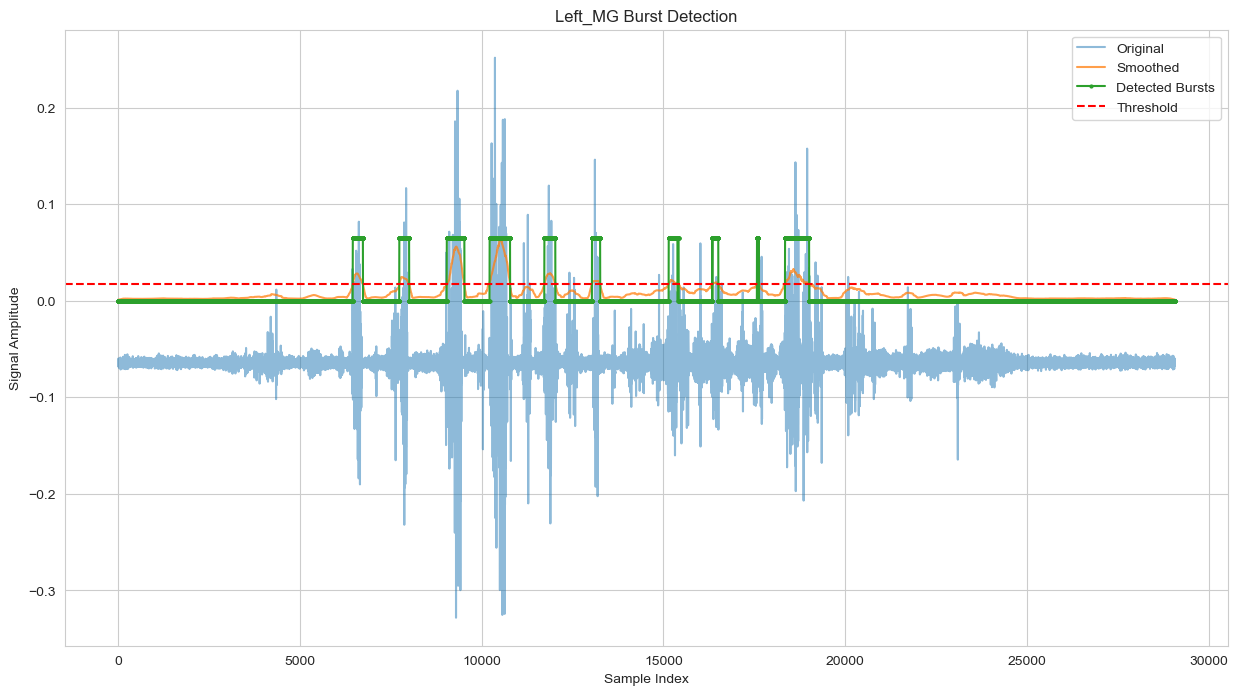

In [9]:
# Plotting
plt.figure(figsize=(15, 8))
plt.plot(emg_signal, label='Original', alpha=0.5)
plt.plot(smoothed_signal, label='Smoothed', alpha=0.75)
plt.plot(bursts * np.max(smoothed_signal), label='Detected Bursts', alpha=1, marker='o', markersize=2)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title(f'{muscle} Burst Detection')
plt.xlabel('Sample Index')
plt.ylabel('Signal Amplitude')
plt.show()

# 2. BioSignalsNotebooks (Example For Comparison)

In [6]:
# Saving the detected bursts for every muscle 
sl = 20 # smooth level (Size of sliding window used during the moving average process) #used to be 40
th = 10 # threshold (To cover activation)

# Visualising the EMG Burst Detection for SOL
plot_duration = 40000 # time in milliseconds
detected_bursts = bsnb.detect_emg_activations(emg_signal = data[muscle], sample_rate = sampling_freq, smooth_level=sl, threshold_level=th, time_units=True, device='CH0', plot_result= True)
# bsnb.detect_emg_activations(emg_signal = data[muscle], sample_rate = sampling_freq, smooth_level=sl, threshold_level=th, time_units=True, device='CH0', plot_result= True)

# 3. Trying to Improve the BioSignalsNotebooks Results by removing the super short bursts

In [7]:
def filter_short_bursts(detected_bursts, min_duration_ms):
    min_duration = min_duration_ms / 1000

    start_times = detected_bursts[0] 
    end_times   = detected_bursts[1] 

    # Calculating the durations of the bursts
    durations = end_times - start_times

    # Creating a boolean mask for bursts longer than the minimum duration
    valid_bursts_mask = durations >= min_duration

    # Filtering the start and end times using the mask
    filtered_start_times = start_times[valid_bursts_mask]
    filtered_end_times = end_times[valid_bursts_mask]

    return [filtered_start_times, filtered_end_times]

def plot_emg_with_bursts(signal, fltrd_detected_bursts):
    fig, ax = plt.subplots(figsize=(15, 4))

    sample_rate = sampling_freq
    start_times = fltrd_detected_bursts[0]
    end_times = fltrd_detected_bursts[1]

    # Converting times to sample indices
    start_indices = (start_times * sample_rate).astype(int)
    end_indices = (end_times * sample_rate).astype(int)

    # Plotting the EMG signal
    ax.plot(signal, label='EMG Signal')

    # Drawing rectangles for each burst
    for start_idx, end_idx in zip(start_indices, end_indices):
        rect = patches.Rectangle((start_idx, min(signal)), end_idx - start_idx, max(signal) - min(signal),
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Formatting the plot
    ax.set_xlabel('Samples')
    ax.set_ylabel('Amplitude')
    ax.set_title('EMG Signal with Detected Muscle Activation Bursts')
    ax.legend()
    plt.show()

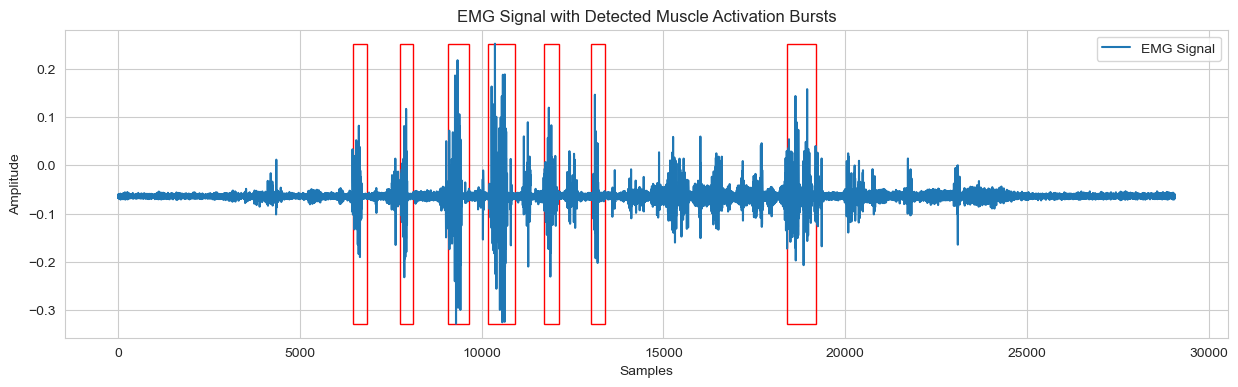

In [8]:
min_duration_ms = 250  # Minimum burst duration in milliseconds

filtered_detected_bursts= filter_short_bursts(detected_bursts, min_duration_ms)
plot_emg_with_bursts(emg_signal, filtered_detected_bursts)